-0.0013062488287687302


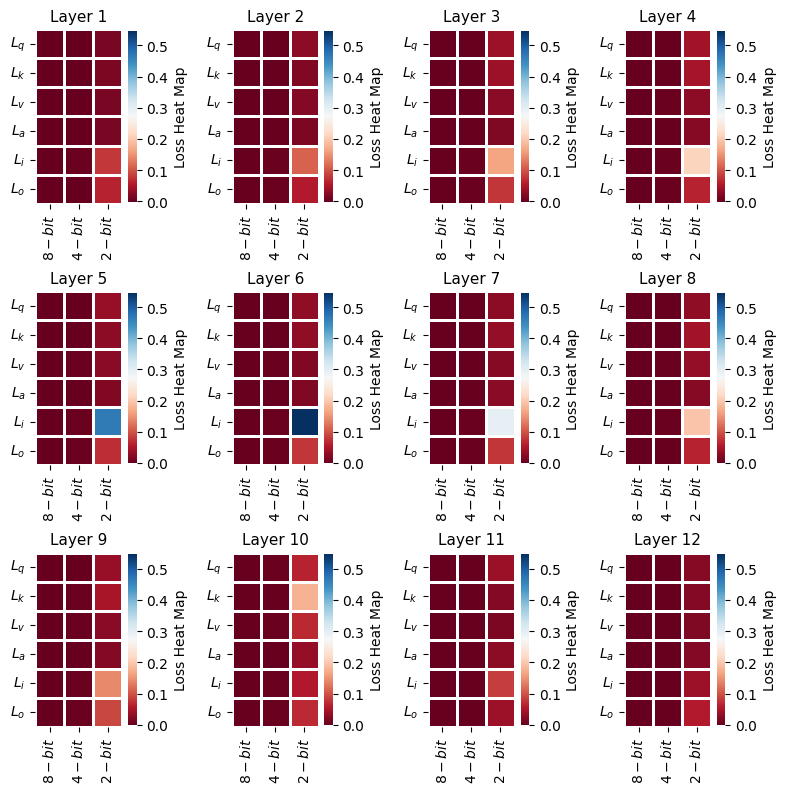

In [2]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

n_runs = 5
batch_num = 128
naive_Ltilde = []
for repeat in range(n_runs):
    start_batch = batch_num * repeat
    end_batch = batch_num * repeat + batch_num - 1
    n_samples = batch_num * 8
    file_name = f'./clado_mpqco_results/bert-base-uncased-squad-v1/Naive/Ltilde_bert-base-uncased-squad-v1/sample_size{n_samples}/Ltilde_calib128_batches_{start_batch}-{end_batch}_bs8.pkl'
    with open(file_name,'rb') as f:
        Ltilde = pickle.load(f)
    naive_Ltilde.append(Ltilde['Ltilde'].diagonal())

Ltilde_hmap = np.mean(naive_Ltilde, axis=0)
L = np.zeros([12, 6, 3])
for i in range(12):
    L[i] = Ltilde_hmap[i*18 : (i+1)*18].reshape(6, 3)

#vmin=-0.05, vmax=0.22
# cmap=cmp,
print(np.min(L))
cols = ["$8-bit$", "$4-bit$", "$2-bit$"]
for i in range(12):
    plt.rcParams['figure.figsize'] = (8,8)
    plt.subplot(3, 4, i+1)
    plt.title(f"Layer {i+1}", size=11)
    ax = sns.heatmap(pd.DataFrame(L[i], columns=cols), yticklabels=["$L_q$","$L_k$","$L_v$","$L_a$","$L_i$","$L_o$"], linewidths=1, vmin=np.min(L), vmax=np.max(L), linecolor='white', square=True, cmap ='RdBu', cbar_kws={'label': 'Loss Heat Map', 'shrink' : 0.98})
    plt.yticks(rotation=0)
    plt.tight_layout()
    #plt.savefig(f"mixed_prec_quant_examples{i+1}.pdf", format="pdf")
plt.show()   

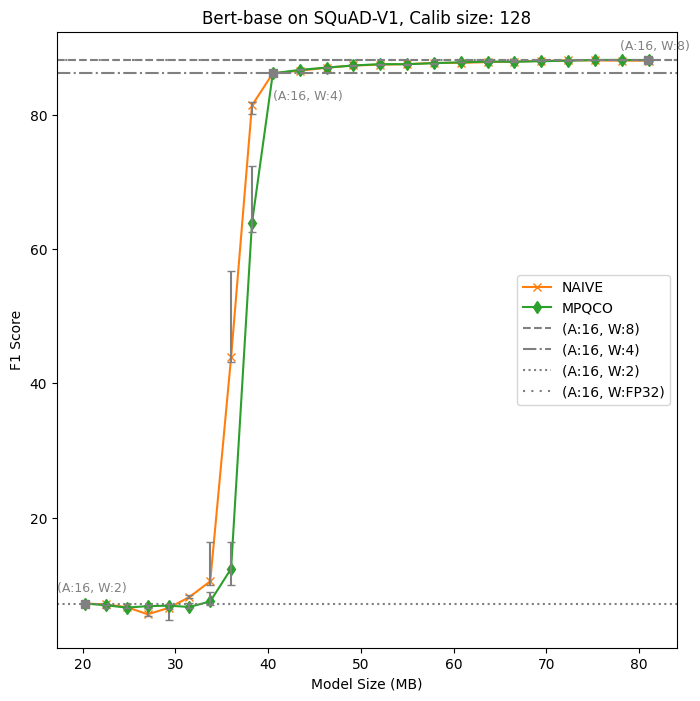

In [3]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

#methods = ["clado", "naive", "mpqco"]
methods = ["naive", "mpqco"]
size_bounds = [20.2505, 22.50055556, 24.75061111, 27.00066667, 29.25072222, 31.50077778, 33.75083333, 36.00088889, 38.25094444, 40.501, 43.39735714, 46.29371429, 49.19007143, 52.08642857, 54.98278571, 57.87914286, 60.7755, 63.67185714, 66.56821429, 69.46457143, 72.36092857, 75.25728571, 78.15364286, 81.05]

n_runs = 5
n_constraints = len(size_bounds)

# n_runs x n_constraints 
# clado_f1 = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
naive_f1 = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
mpqco_f1 = [[0 for _ in range(n_constraints)] for _ in range(n_runs)] 
# clado_exact_match = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
naive_exact_match = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
mpqco_exact_match = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
# clado_eval_loss = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
naive_eval_loss = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
mpqco_eval_loss = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]

batch_num = 128
for repeat in range(n_runs):
    start_batch = batch_num * repeat
    end_batch = batch_num * repeat + batch_num - 1
    n_samples = batch_num * 8
    file_name = f'./clado_mpqco_results/bert-base-uncased-squad-v1/MPQCO/MPQCO_res/sample_size{n_samples}/mpqco_a16_w8-4-2_calib128_batches_{start_batch}-{end_batch}_bs8.pkl'
    with open(file_name,'rb') as f:
        res = pickle.load(f)
    j = 0
    for item in res['mpqco_res']:
        eval_f1, eval_exact_match, eval_loss, size, bitops, _ = item
        mpqco_f1[repeat][j] = eval_f1
        mpqco_exact_match[repeat][j] = eval_exact_match
        mpqco_eval_loss[repeat][j] = eval_loss
        j += 1
    file_name = f'./clado_mpqco_results/bert-base-uncased-squad-v1/Naive/Naive_res/sample_size{n_samples}/naive_a16_w8-4-2_calib128_batches_{start_batch}-{end_batch}_bs8.pkl'
    with open(file_name,'rb') as f:
        res = pickle.load(f)
    j = 0
    for item in res['naive_res']:
        eval_f1, eval_exact_match, eval_loss, size, bitops, _ = item
        naive_f1[repeat][j] = eval_f1
        naive_exact_match[repeat][j] = eval_exact_match
        naive_eval_loss[repeat][j] = eval_loss
        j += 1        


# default colors
# ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# f1_clado = np.array(clado_f1)
f1_naive = np.array(naive_f1)
f1_mpqco = np.array(mpqco_f1)


xs = size_bounds
# y_clado =  np.mean(f1_clado, axis=0)
y_naive =  np.mean(f1_naive, axis=0)
y_mpqco =  np.mean(f1_mpqco, axis=0)

# creating error
y_errormin_naive = np.quantile(f1_naive, 0.5, axis=0) - np.quantile(f1_naive, 0.25, axis=0)
y_errormax_naive = np.quantile(f1_naive, 0.75, axis=0) - np.quantile(f1_naive, 0.5, axis=0)
y_errormin_mpqco = np.quantile(f1_mpqco, 0.5, axis=0) - np.quantile(f1_mpqco, 0.25, axis=0)
y_errormax_mpqco = np.quantile(f1_mpqco, 0.75, axis=0) - np.quantile(f1_mpqco, 0.5, axis=0)
y_error_naive =[y_errormin_naive, y_errormax_naive]
y_error_mpqco =[y_errormin_mpqco, y_errormax_mpqco]

#plt.rcParams['figure.figsize'] = (10,5)

# plt.plot(xs, y_clado[0:-1], marker='o', label=f'CLADO')
plt.plot(xs, np.quantile(f1_naive, 0.5, axis=0), marker='x', label=f'NAIVE', color='#ff7f0e')
plt.errorbar(xs, np.quantile(f1_naive, 0.5, axis=0), yerr = y_error_naive, linestyle = 'None', ecolor='gray', capsize=3)
plt.plot(xs, np.quantile(f1_mpqco, 0.5, axis=0), marker='d', label=f'MPQCO', color='#2ca02c')
plt.errorbar(xs, np.quantile(f1_mpqco, 0.5, axis=0), yerr = y_error_mpqco, linestyle = 'None', ecolor='gray', capsize=3)

plt.plot([81.0],[88.16565997853645], color='gray', marker='s')
plt.annotate("(A:16, W:8)", (81 - 3.0, 88.16565997853645 + 1.6), size=9, color='gray')
plt.axhline(y=88.16565997853645, color='gray', linestyle='--', label='(A:16, W:8)')
# model size is:  81.0, {'eval_exact_match': 80.96499526963103, 'eval_f1': 88.16565997853645, 'eval_loss': 0.9958921074867249}

plt.plot([40.5],[86.180744805817], color='gray', marker='s')
plt.annotate("(A:16, W:4)", (40.5, 86.180744805817 -3.8), size=9, color='gray')
plt.axhline(y=86.180744805817, color='gray', linestyle='-.', label='(A:16, W:4)')
# model size is:  40.5, {'eval_exact_match': 77.78618732261117, 'eval_f1': 86.180744805817, 'eval_loss': 1.0381795167922974}

plt.plot([20.25],[7.186451306104543,], color='gray', marker='s')
plt.annotate("(A:16, W:2)", (20.25 - 3.0, 7.186451306104543 +1.8,), size=9, color='gray')
plt.axhline(y=7.186451306104543, color='gray', linestyle=':', label='(A:16, W:2)')
# model size is:  20.25, {'eval_exact_match': 0.3216650898770104, 'eval_f1': 7.186451306104543, 'eval_loss': 5.938819885253906}

plt.axhline(y=88.2139240722649, color='gray', linestyle=(0, (1, 3)), label='(A:16, W:FP32)')
# fp32 metrics:  {'eval_exact_match': 80.90823084200568, 'eval_f1': 88.2139240722649, 'eval_loss': 0.9968518614768982}

plt.title('Bert-base on SQuAD-V1, Calib size: 128')
plt.ylabel('F1 Score')
plt.xlabel('Model Size (MB)')
plt.legend()
plt.show()


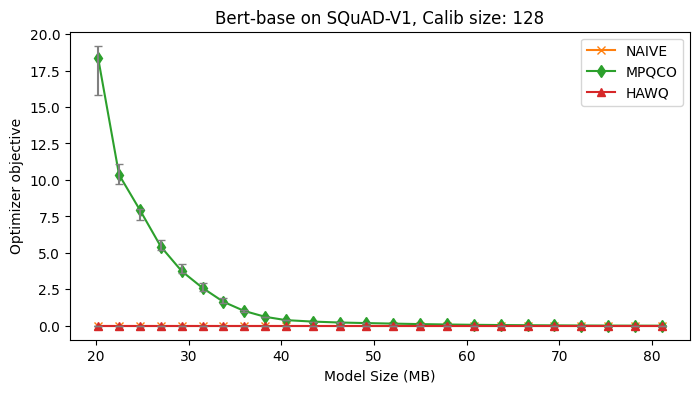

In [7]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

#methods = ["clado", "naive", "mpqco"]
methods = ["naive", "mpqco"]
size_bounds = [20.2505, 22.50055556, 24.75061111, 27.00066667, 29.25072222, 31.50077778, 33.75083333, 36.00088889, 38.25094444, 40.501, 43.39735714, 46.29371429, 49.19007143, 52.08642857, 54.98278571, 57.87914286, 60.7755, 63.67185714, 66.56821429, 69.46457143, 72.36092857, 75.25728571, 78.15364286, 81.05]

n_runs = 5
n_constraints = len(size_bounds)

# n_runs x n_constraints 
# clado_obj = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
naive_obj = [[0 for _ in range(n_constraints)] for _ in range(n_runs)]
mpqco_obj = [[0 for _ in range(n_constraints)] for _ in range(n_runs)] 
hawq_obj = [[0 for _ in range(n_constraints)] for _ in range(n_runs)] 

batch_num = 128
for repeat in range(n_runs):
    start_batch = batch_num * repeat
    end_batch = batch_num * repeat + batch_num - 1
    n_samples = batch_num * 8
    file_name = f'./clado_mpqco_results/bert-base-uncased-squad-v1/MPQCO/MPQCO_optimal_opjectives_bert-base-uncased-squad-v1/sample_size{n_samples}/mpqco_a16_w8-4-2_calib128_batches_{start_batch}-{end_batch}_bs8_optimization_objective.pkl'
    with open(file_name,'rb') as f:
        res = pickle.load(f)
    for j, obj in enumerate(res['mpqco_objectives']):
        mpqco_obj[repeat][j] = obj

    file_name = f'./clado_mpqco_results/bert-base-uncased-squad-v1/Naive/Naive_optimal_opjectives_bert-base-uncased-squad-v1/sample_size{n_samples}/naive_a16_w8-4-2_calib128_batches_{start_batch}-{end_batch}_bs8_optimization_objective.pkl'
    with open(file_name,'rb') as f:
        res = pickle.load(f)
    for j, obbj in enumerate(res['naive_objectives']):
        naive_obj[repeat][j] = obj
    
    file_name = f'./clado_mpqco_results/bert-base-uncased-squad-v1/HAWQ/Hawq_optimal_opjectives_bert-base-uncased-squad-v1/sample_size{n_samples}/hawq_a16_w8-4-2_calib128_batches_{start_batch}-{end_batch}_bs8_optimization_objective.pkl'
    with open(file_name,'rb') as f:
        res = pickle.load(f)
    for j, obbj in enumerate(res['hawq_objectives']):
        hawq_obj[repeat][j] = obj   


# default colors
# ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# obj_clado = np.array(clado_obj)
obj_naive = np.array(naive_obj)
obj_mpqco = np.array(mpqco_obj)
obj_hawq = np.array(hawq_obj)

xs = size_bounds

# creating error
y_errormin_naive = np.quantile(obj_naive, 0.5, axis=0) - np.quantile(obj_naive, 0.25, axis=0)
y_errormax_naive = np.quantile(obj_naive, 0.75, axis=0) - np.quantile(obj_naive, 0.5, axis=0)
y_errormin_mpqco = np.quantile(obj_mpqco, 0.5, axis=0) - np.quantile(obj_mpqco, 0.25, axis=0)
y_errormax_mpqco = np.quantile(obj_mpqco, 0.75, axis=0) - np.quantile(obj_mpqco, 0.5, axis=0)
y_errormin_hawq = np.quantile(obj_hawq, 0.5, axis=0) - np.quantile(obj_hawq, 0.25, axis=0)
y_errormax_hawq = np.quantile(obj_hawq, 0.75, axis=0) - np.quantile(obj_hawq, 0.5, axis=0)

y_error_naive = [y_errormin_naive, y_errormax_naive]
y_error_mpqco = [y_errormin_mpqco, y_errormax_mpqco]
y_error_hawq = [y_errormin_hawq, y_errormax_hawq]

#plt.rcParams['figure.figsize'] = (10,5)

# plt.plot(xs, y_clado[0:-1], marker='o', label=f'CLADO')
plt.plot(xs, np.quantile(obj_naive, 0.5, axis=0), marker='x', label=f'NAIVE', color='#ff7f0e')
plt.errorbar(xs, np.quantile(obj_naive, 0.5, axis=0), yerr = y_error_naive, linestyle = 'None', ecolor='gray', capsize=3)
plt.plot(xs, np.quantile(obj_mpqco, 0.5, axis=0), marker='d', label=f'MPQCO', color='#2ca02c')
plt.errorbar(xs, np.quantile(obj_mpqco, 0.5, axis=0), yerr = y_error_mpqco, linestyle = 'None', ecolor='gray', capsize=3)
plt.plot(xs, np.quantile(obj_hawq, 0.5, axis=0), marker='^', label=f'HAWQ', color='#d62728')
plt.errorbar(xs, np.quantile(obj_hawq, 0.5, axis=0), yerr = y_error_hawq, linestyle = 'None', ecolor='gray', capsize=3)

# plt.plot([81.0],[88.16565997853645], color='gray', marker='s')
# plt.annotate("(A:16, W:8)", (81 - 3.0, 88.16565997853645 + 1.6), size=9, color='gray')
# plt.axhline(y=88.16565997853645, color='gray', linestyle='--', label='(A:16, W:8)')
# # model size is:  81.0, {'eval_exact_match': 80.96499526963103, 'eval_f1': 88.16565997853645, 'eval_loss': 0.9958921074867249}

# plt.plot([40.5],[86.180744805817], color='gray', marker='s')
# plt.annotate("(A:16, W:4)", (40.5, 86.180744805817 -3.8), size=9, color='gray')
# plt.axhline(y=86.180744805817, color='gray', linestyle='-.', label='(A:16, W:4)')
# # model size is:  40.5, {'eval_exact_match': 77.78618732261117, 'eval_f1': 86.180744805817, 'eval_loss': 1.0381795167922974}

# plt.plot([20.25],[7.186451306104543,], color='gray', marker='s')
# plt.annotate("(A:16, W:2)", (20.25 - 3.0, 7.186451306104543 +1.8,), size=9, color='gray')
# plt.axhline(y=7.186451306104543, color='gray', linestyle=':', label='(A:16, W:2)')
# # model size is:  20.25, {'eval_exact_match': 0.3216650898770104, 'eval_f1': 7.186451306104543, 'eval_loss': 5.938819885253906}

# plt.axhline(y=88.2139240722649, color='gray', linestyle=(0, (1, 3)), label='(A:16, W:FP32)')
# # fp32 metrics:  {'eval_exact_match': 80.90823084200568, 'eval_f1': 88.2139240722649, 'eval_loss': 0.9968518614768982}

plt.title('Bert-base on SQuAD-V1, Calib size: 128')
plt.ylabel('Optimizer objective')
plt.xlabel('Model Size (MB)')
plt.legend()
plt.show()


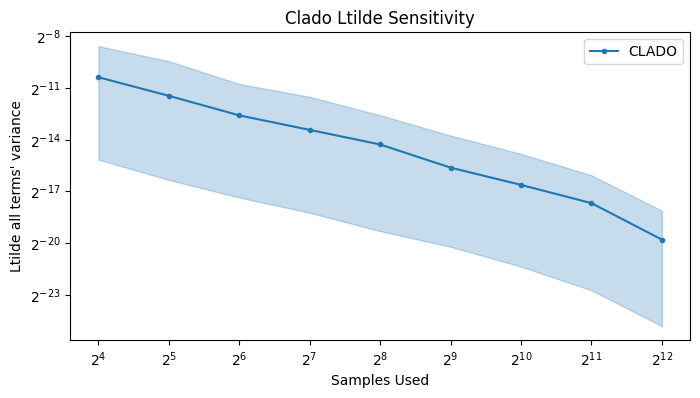

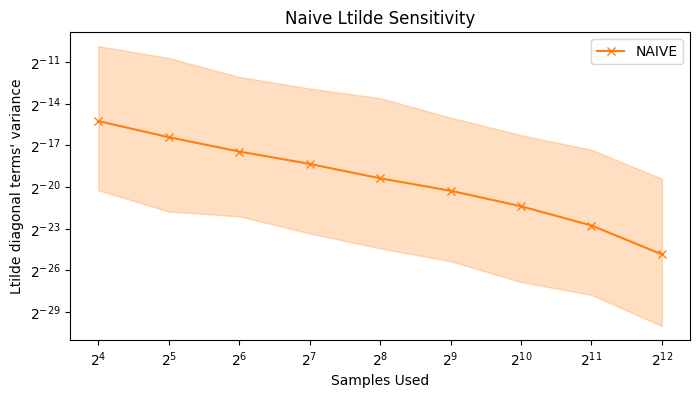

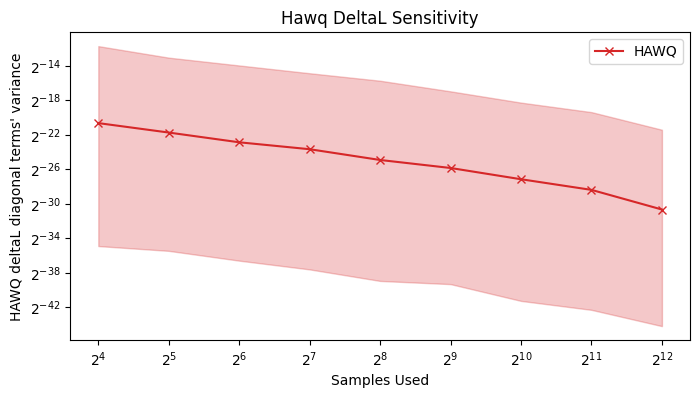

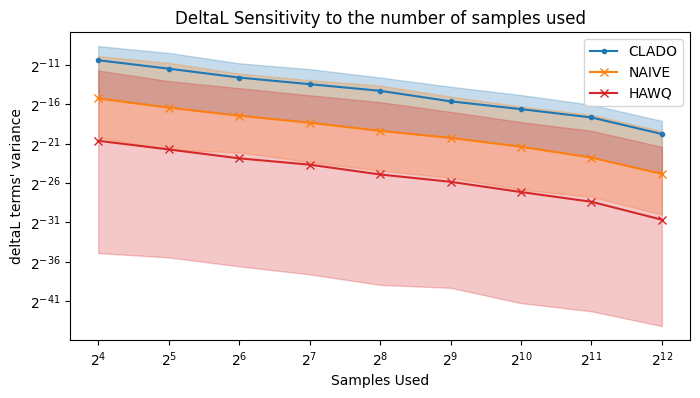

In [4]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

n_runs = 24
num_batches = [2, 4, 8, 16, 32, 64, 128, 256, 512]
num_samples = [n_batch * 8 for n_batch in num_batches]

clado_var = [0] * len(num_batches)
for i, n_batch in enumerate(num_batches):
    clado_Ltilde = []
    for run in range(n_runs):
        file_name = f'./clado_mpqco_results/bert-base-uncased-squad-v1/sensitivity/Ltilde_clado/sample_size{num_samples[i]}/Ltilde_calib128_multi-batches_run{run+1}_bs8.pkl'
        with open(file_name,'rb') as f:
            Ltilde = pickle.load(f) 
        clado_Ltilde.append(Ltilde['Ltilde'].flatten())
    clado_var[i] = np.var(clado_Ltilde, axis=0)

naive_var = [0] * len(num_batches)
for i, n_batch in enumerate(num_batches):
    naive_Ltilde = []
    for run in range(n_runs):
        file_name = f'./clado_mpqco_results/bert-base-uncased-squad-v1/sensitivity/Ltilde_naive/sample_size{num_samples[i]}/Ltilde_calib128_multi-batches_run{run+1}_bs8.pkl'
        with open(file_name,'rb') as f:
            Ltilde = pickle.load(f) 
        naive_Ltilde.append(Ltilde['Ltilde'].diagonal())
    naive_var[i] = np.var(naive_Ltilde, axis=0)

hawq_var = [0] * len(num_batches)
for i, n_batch in enumerate(num_batches):
    hawq_DeltaL = []
    for run in range(n_runs):
        file_name = f'./clado_mpqco_results/bert-base-uncased-squad-v1/sensitivity/DeltaL_hawq/sample_size{num_samples[i]}/DELTAL_HAWQ_multi-batches_run{run+1}_bs8.pkl'
        with open(file_name,'rb') as f:
            DeltaL = pickle.load(f) 
        hawq_DeltaL.append(DeltaL['DeltaL'].diagonal())
    hawq_var[i] = np.var(hawq_DeltaL, axis=0)

plt.rcParams['figure.figsize'] = (8,4)
plt.plot(num_samples, np.quantile(clado_var, 0.5, axis=1), marker='.', label=f'CLADO', color='#1f77b4')
plt.fill_between(num_samples, np.quantile(clado_var, 0.75, axis=1), np.quantile(clado_var, 0.25, axis=1), alpha=0.25, color='#1f77b4')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.xticks(num_samples)
plt.legend()
plt.ylabel("Ltilde all terms' variance")
plt.xlabel('Samples Used')
plt.title(f'Clado Ltilde Sensitivity')
plt.show()

plt.rcParams['figure.figsize'] = (8,4)
plt.plot(num_samples, np.quantile(naive_var, 0.5, axis=1), marker='x', label=f'NAIVE', color='#ff7f0e')
plt.fill_between(num_samples, np.quantile(naive_var, 0.75, axis=1), np.quantile(naive_var, 0.25, axis=1), alpha=0.25, color='#ff7f0e')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.xticks(num_samples)
plt.legend()
plt.ylabel("Ltilde diagonal terms' variance")
plt.xlabel('Samples Used')
plt.title(f'Naive Ltilde Sensitivity')
plt.show()

plt.rcParams['figure.figsize'] = (8,4)
plt.plot(num_samples, np.quantile(hawq_var, 0.5, axis=1), marker='x', label=f'HAWQ', color='#d62728')
plt.fill_between(num_samples, np.quantile(hawq_var, 0.75, axis=1), np.quantile(hawq_var, 0.25, axis=1), alpha=0.25, color='#d62728')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.xticks(num_samples)
plt.legend()
plt.ylabel("HAWQ deltaL diagonal terms' variance")
plt.xlabel('Samples Used')
plt.title(f'Hawq DeltaL Sensitivity')
plt.show()


plt.rcParams['figure.figsize'] = (8,4)
plt.plot(num_samples, np.quantile(clado_var, 0.5, axis=1), marker='.', label=f'CLADO', color='#1f77b4')
plt.fill_between(num_samples, np.quantile(clado_var, 0.75, axis=1), np.quantile(clado_var, 0.25, axis=1), alpha=0.25, color='#1f77b4')
plt.plot(num_samples, np.quantile(naive_var, 0.5, axis=1), marker='x', label=f'NAIVE', color='#ff7f0e')
plt.fill_between(num_samples, np.quantile(naive_var, 0.75, axis=1), np.quantile(naive_var, 0.25, axis=1), alpha=0.25, color='#ff7f0e')
plt.plot(num_samples, np.quantile(hawq_var, 0.5, axis=1), marker='x', label=f'HAWQ', color='#d62728')
plt.fill_between(num_samples, np.quantile(hawq_var, 0.75, axis=1), np.quantile(hawq_var, 0.25, axis=1), alpha=0.25, color='#d62728')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.xticks(num_samples)
plt.legend()
plt.ylabel("deltaL terms' variance")
plt.xlabel('Samples Used')
plt.title(f'DeltaL Sensitivity to the number of samples used')
plt.show()